https://marinecadastre.gov/data/

[Office for Coastal Management, 2023: Nationwide Automatic Identification System 2022, https://www.fisheries.noaa.gov/inport/item/67336](https://www.fisheries.noaa.gov/inport/item/67336)

https://coast.noaa.gov/data/marinecadastre/ais/data-dictionary.pdf

### M.1371 : Technical characteristics for an automatic identification system using time division multiple access in the VHF maritime mobile frequency band (Rec. ITU-R M.1371-5 )

https://www.itu.int/rec/R-REC-M.1371-5-201402-I/en

| Identifier No. | Vessel Type                                                  |
| -------------- | ------------------------------------------------------------ |
| 50             | Special craft                                                |
| 51             | Pilot vessel                                                 |
| 52             | Search and rescue vessels                                    |
| 53             | Tugs                                                         |
| 54             | Port tenders                                                 |
| 55             | Vessels with anti-pollution facilities or equipment          |
| 56             | Law enforcement vessels                                      |
| 57             | Spare – for assignments to local vessels                     |
| 58             | Spare – for assignments to local vessels                     |
| 59             | Medical transports (as defined in the 1949 Geneva Conventions and Additional Protocols) |
| 60             | Ships and aircraft of States not parties to an armed conflict |
| 0X             | Fishing vessels                                              |
| 1X             | Carrying dangerous goods (DG), harmful substances (HS), or marine pollutants (MP), or IMO hazard or pollutant category X |
| 2X             | Towing vessels                                               |
| 3X             | Vessels engaged in dredging or underwater operations         |
| 4X             | Vessels engaged in diving operations                         |
| 5X             | Reserved for future use                                      |
| 6X             | Passenger ships                                              |
| 7X             | Cargo ships                                                  |
| 8X             | Tankers                                                      |
| 9X             | Other types of ships                                         |

Table 53: Identifiers to be used by ships to report their type (Rec. ITU-R M.1371-5)

| Navigation Status | Description               |
|-------------------|---------------------------|
| 0                 | Under way using engine    |
| 1                 | At anchor                 |
| 2                 | Not under command         |
| 3                 | Restricted maneuverability|
| 4                 | Constrained by her draught|
| 5                 | Moored                    |
| 6                 | Aground                   |
| 7                 | Engaged in fishing        |
| 8                 | Under way sailing         |

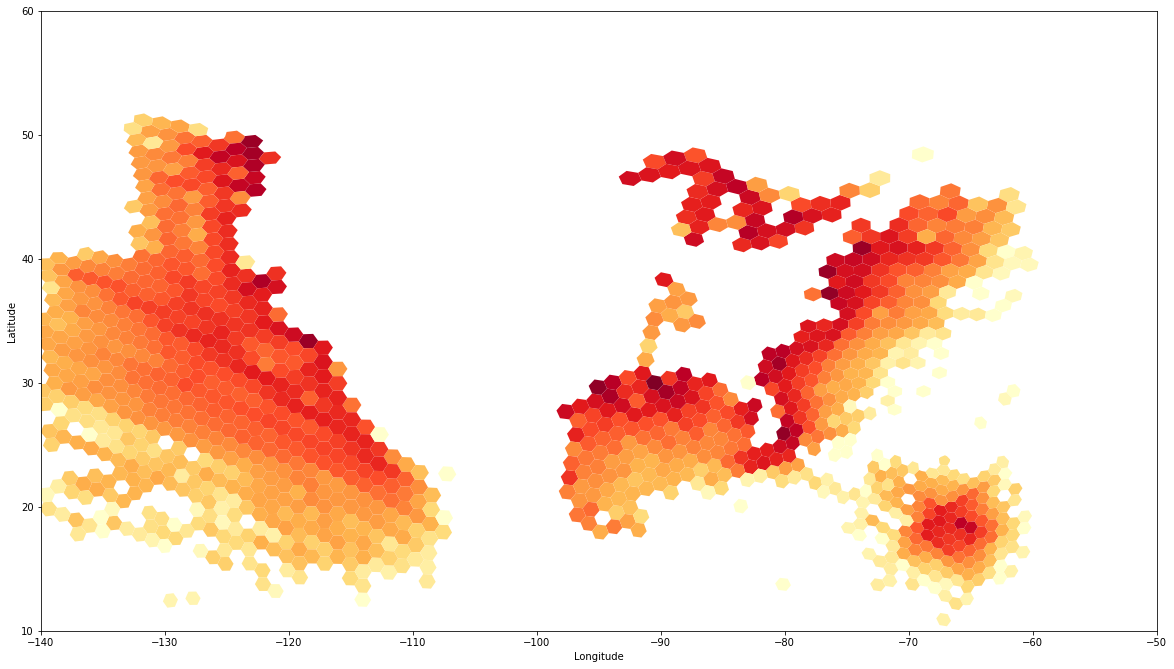

In [0]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import h3
import h3_pyspark
from pyspark.sql import functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import matplotlib.colors as colors

# Define the lat/lon boundaries
min_lat, max_lat, min_lon, max_lon = 10, 60, -140, -50

# Define the hexagon resolution
resolution = 3

# Read the spark dataframe
df_ais_june_vesseltype_70 = spark.read.table("ais.june").filter("VesselType = 70")

# Add a 'resolution' column
df_ais_june_vesseltype_70 = df_ais_june_vesseltype_70.withColumn('resolution', F.lit(resolution))

# Create an h3 index for each location using the UDF
df_ais_june_vesseltype_70 = df_ais_june_vesseltype_70.withColumn('hex_id', h3_pyspark.geo_to_h3(df_ais_june_vesseltype_70['LAT'], df_ais_june_vesseltype_70['LON'], df_ais_june_vesseltype_70['resolution']))

# Count the occurrences of each hex_id to get the density
df_density = df_ais_june_vesseltype_70.groupBy('hex_id').count()

# Convert the density dataframe to Pandas
df_density_pd = df_density.toPandas()

# Create polygons for each unique hex_id, and filter them based on the bounding box
hex_polygons = []
hex_ids = []
for hex_id in df_density_pd['hex_id'].unique():
    hex_boundary = h3.h3_to_geo_boundary(hex_id)
    polygon = Polygon([(lon, lat) for lat, lon in hex_boundary])
    # create a point based on the polygon's centroid and check if it lies within the bounding box
    centroid = polygon.centroid
    if min_lat <= centroid.y <= max_lat and min_lon <= centroid.x <= max_lon:
        hex_polygons.append(polygon)
        hex_ids.append(hex_id)

# Filter the density dataframe to only include hexagons within the bounding box
df_density_pd = df_density_pd[df_density_pd['hex_id'].isin(hex_ids)]

# Replace inf with max non-inf value and NaN with 1
df_density_pd.loc[df_density_pd['count'] == np.inf, 'count'] = df_density_pd.loc[df_density_pd['count'] != np.inf, 'count'].max()
df_density_pd['count'] = df_density_pd['count'].replace({0:1}).fillna(1)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(df_density_pd, geometry=hex_polygons)

# Plot the choropleth map
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
gdf.plot(column='count', cmap='YlOrRd', norm=colors.LogNorm(vmin=gdf['count'].min(), vmax=gdf['count'].max()), missing_kwds={'color': 'white'}, ax=ax)
plt.xlim(min_lon, max_lon)
plt.ylim(min_lat, max_lat)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

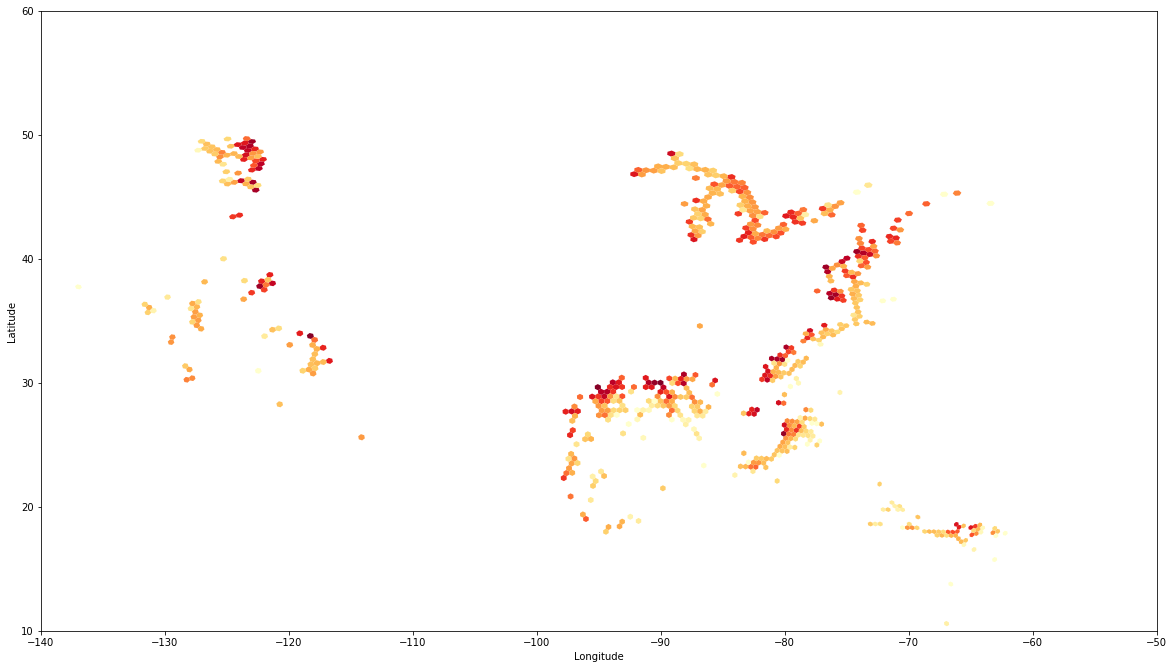

In [0]:
# Import required libraries
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import h3
import h3_pyspark
from pyspark.sql import functions as F
import matplotlib.colors as colors

# Define the lat/lon boundaries
min_lat, max_lat, min_lon, max_lon = 10, 60, -140, -50

# Define the hexagon resolution
resolution = 4

# Read the spark dataframe
df_ais_june = spark.read.table("ais.june").filter("VesselType = 70")

# Add a 'resolution' column
df_ais_june = df_ais_june.withColumn('resolution', F.lit(resolution))

# Create an h3 index for each location
df_ais_june = df_ais_june.withColumn('hex_id', h3_pyspark.geo_to_h3(df_ais_june['LAT'], df_ais_june['LON'], F.lit(resolution)))

# Filter for status values 1, 2, and 5
df_filtered = df_ais_june.filter(df_ais_june['Status'].isin([1, 2, 5]))

# Count the occurrences of each hex_id to get the density
df_density = df_filtered.groupBy('hex_id').count()

# Convert the density dataframe to Pandas
df_density_pd = df_density.toPandas()

# Create polygons for each unique hex_id, and filter them based on the bounding box
hex_polygons = []
hex_ids = []
for hex_id in df_density_pd['hex_id'].unique():
    hex_boundary = h3.h3_to_geo_boundary(hex_id)
    polygon = Polygon([(lon, lat) for lat, lon in hex_boundary])
    # create a point based on the polygon's centroid and check if it lies within the bounding box
    centroid = polygon.centroid
    if min_lat <= centroid.y <= max_lat and min_lon <= centroid.x <= max_lon:
        hex_polygons.append(polygon)
        hex_ids.append(hex_id)

# Filter the density dataframe to only include hexagons within the bounding box
df_density_pd = df_density_pd[df_density_pd['hex_id'].isin(hex_ids)]

# Replace inf with max non-inf value and NaN with 1
df_density_pd.loc[df_density_pd['count'] == np.inf, 'count'] = df_density_pd.loc[df_density_pd['count'] != np.inf, 'count'].max()
df_density_pd['count'] = df_density_pd['count'].replace({0:1}).fillna(1)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(df_density_pd, geometry=hex_polygons)

# Plot the choropleth map with the YlOrRd colormap
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
gdf.plot(column='count', cmap='YlOrRd', norm=colors.LogNorm(vmin=gdf['count'].min(), vmax=gdf['count'].max()), missing_kwds={'color': 'white'}, ax=ax)
plt.xlim(min_lon, max_lon)
plt.ylim(min_lat, max_lat)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

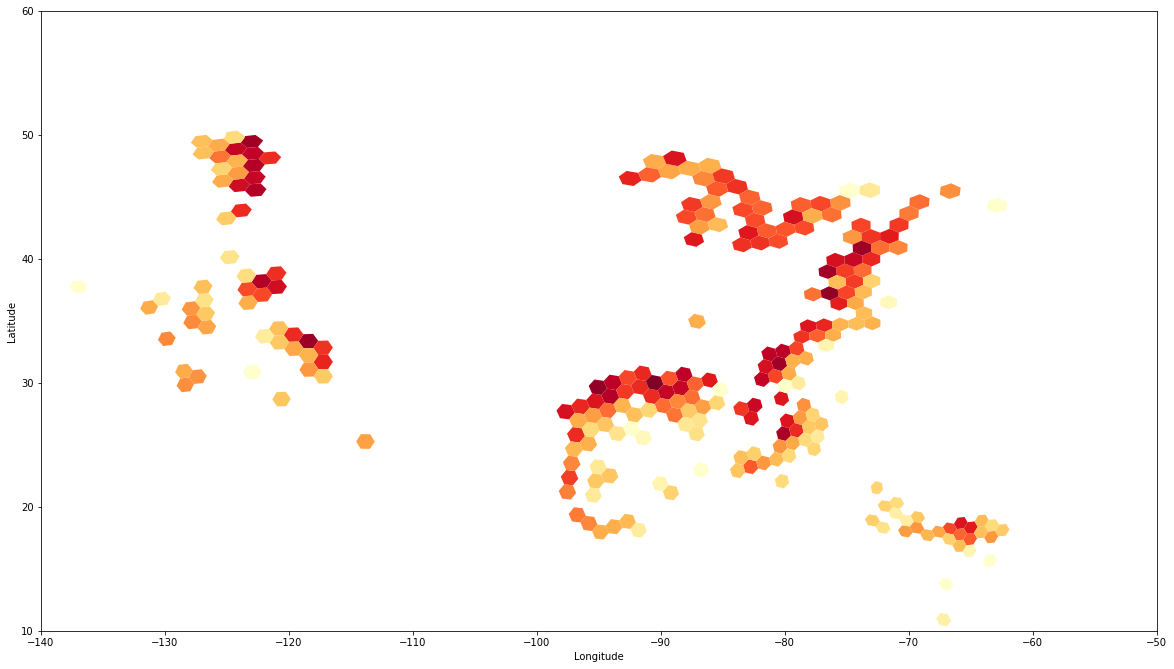

In [0]:
# Import required libraries
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import h3
import h3_pyspark
from pyspark.sql import functions as F
import matplotlib.colors as colors

# Define the lat/lon boundaries
min_lat, max_lat, min_lon, max_lon = 10, 60, -140, -50

# Define the hexagon resolution
resolution = 3

# Read the spark dataframe
df_ais_june = spark.read.table("ais.june").filter("VesselType = 70")

# Add a 'resolution' column
df_ais_june = df_ais_june.withColumn('resolution', F.lit(resolution))

# Create an h3 index for each location
df_ais_june = df_ais_june.withColumn('hex_id', h3_pyspark.geo_to_h3(df_ais_june['LAT'], df_ais_june['LON'], F.lit(resolution)))

# Filter for status values 1, 2, and 5
df_filtered = df_ais_june.filter(df_ais_june['Status'].isin([1, 2, 5]))

# Count the occurrences of each hex_id to get the density
df_density = df_filtered.groupBy('hex_id').count()

# Convert the density dataframe to Pandas
df_density_pd = df_density.toPandas()

# Create polygons for each unique hex_id, and filter them based on the bounding box
hex_polygons = []
hex_ids = []
for hex_id in df_density_pd['hex_id'].unique():
    hex_boundary = h3.h3_to_geo_boundary(hex_id)
    polygon = Polygon([(lon, lat) for lat, lon in hex_boundary])
    # create a point based on the polygon's centroid and check if it lies within the bounding box
    centroid = polygon.centroid
    if min_lat <= centroid.y <= max_lat and min_lon <= centroid.x <= max_lon:
        hex_polygons.append(polygon)
        hex_ids.append(hex_id)

# Filter the density dataframe to only include hexagons within the bounding box
df_density_pd = df_density_pd[df_density_pd['hex_id'].isin(hex_ids)]

# Replace inf with max non-inf value and NaN with 1
df_density_pd.loc[df_density_pd['count'] == np.inf, 'count'] = df_density_pd.loc[df_density_pd['count'] != np.inf, 'count'].max()
df_density_pd['count'] = df_density_pd['count'].replace({0:1}).fillna(1)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(df_density_pd, geometry=hex_polygons)

# Plot the choropleth map with the YlOrRd colormap
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
gdf.plot(column='count', cmap='YlOrRd', norm=colors.LogNorm(vmin=gdf['count'].min(), vmax=gdf['count'].max()), missing_kwds={'color': 'white'}, ax=ax)
plt.xlim(min_lon, max_lon)
plt.ylim(min_lat, max_lat)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

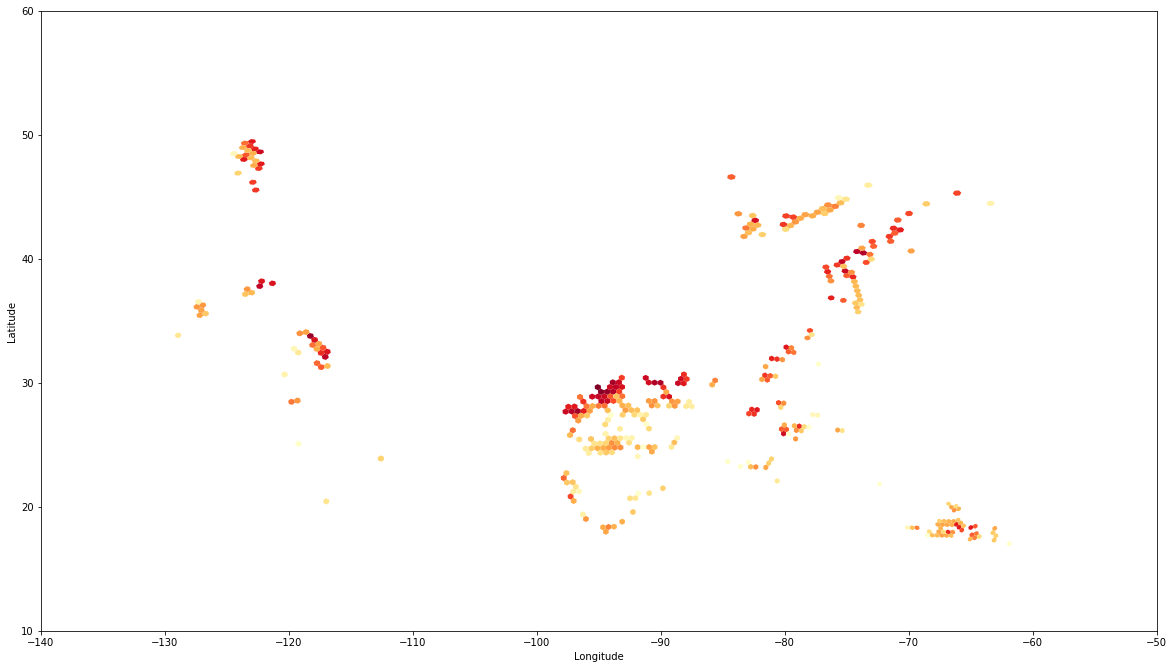

In [0]:
# Import required libraries
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import h3
import h3_pyspark
from pyspark.sql import functions as F
import matplotlib.colors as colors

# Define the lat/lon boundaries
min_lat, max_lat, min_lon, max_lon = 10, 60, -140, -50

# Define the hexagon resolution
resolution = 4

# Read the spark dataframe
df_ais_june = spark.read.table("ais.june").filter("VesselType = 80")

# Add a 'resolution' column
df_ais_june = df_ais_june.withColumn('resolution', F.lit(resolution))

# Create an h3 index for each location
df_ais_june = df_ais_june.withColumn('hex_id', h3_pyspark.geo_to_h3(df_ais_june['LAT'], df_ais_june['LON'], F.lit(resolution)))

# Filter for status values 1, 2, and 5
df_filtered = df_ais_june.filter(df_ais_june['Status'].isin([1, 2, 5]))

# Count the occurrences of each hex_id to get the density
df_density = df_filtered.groupBy('hex_id').count()

# Convert the density dataframe to Pandas
df_density_pd = df_density.toPandas()

# Create polygons for each unique hex_id, and filter them based on the bounding box
hex_polygons = []
hex_ids = []
for hex_id in df_density_pd['hex_id'].unique():
    hex_boundary = h3.h3_to_geo_boundary(hex_id)
    polygon = Polygon([(lon, lat) for lat, lon in hex_boundary])
    # create a point based on the polygon's centroid and check if it lies within the bounding box
    centroid = polygon.centroid
    if min_lat <= centroid.y <= max_lat and min_lon <= centroid.x <= max_lon:
        hex_polygons.append(polygon)
        hex_ids.append(hex_id)

# Filter the density dataframe to only include hexagons within the bounding box
df_density_pd = df_density_pd[df_density_pd['hex_id'].isin(hex_ids)]

# Replace inf with max non-inf value and NaN with 1
df_density_pd.loc[df_density_pd['count'] == np.inf, 'count'] = df_density_pd.loc[df_density_pd['count'] != np.inf, 'count'].max()
df_density_pd['count'] = df_density_pd['count'].replace({0:1}).fillna(1)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(df_density_pd, geometry=hex_polygons)

# Plot the choropleth map with the YlOrRd colormap
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
gdf.plot(column='count', cmap='YlOrRd', norm=colors.LogNorm(vmin=gdf['count'].min(), vmax=gdf['count'].max()), missing_kwds={'color': 'white'}, ax=ax)
plt.xlim(min_lon, max_lon)
plt.ylim(min_lat, max_lat)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

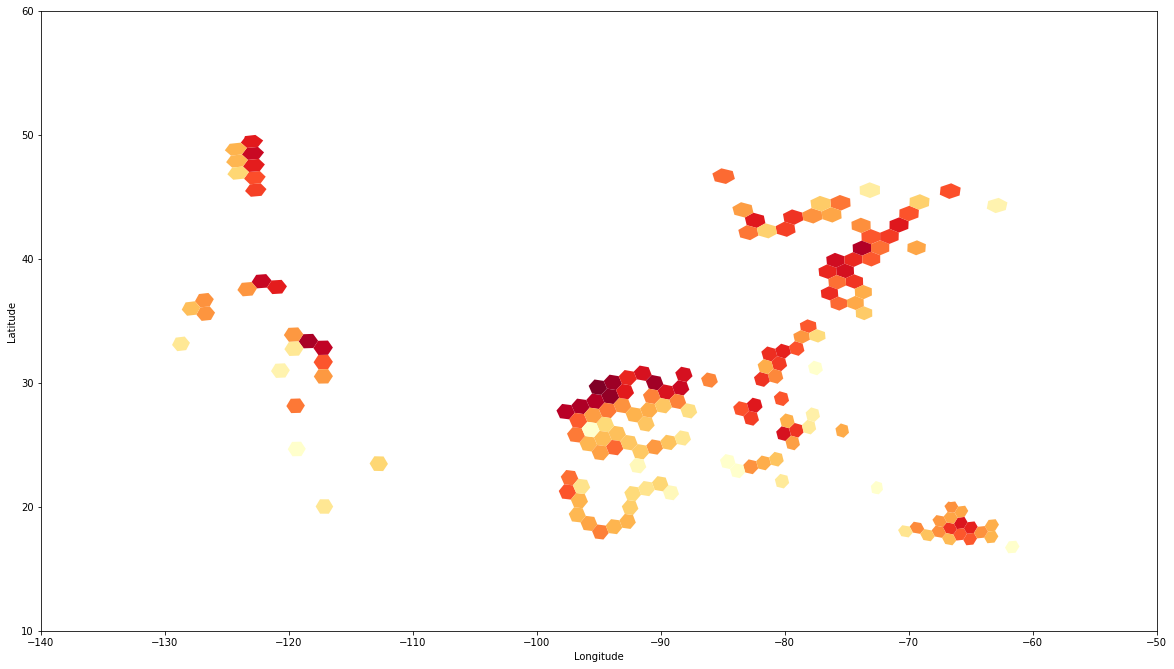

In [0]:
# Import required libraries
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
import h3
import h3_pyspark
from pyspark.sql import functions as F
import matplotlib.colors as colors

# Define the lat/lon boundaries
min_lat, max_lat, min_lon, max_lon = 10, 60, -140, -50

# Define the hexagon resolution
resolution = 3

# Read the spark dataframe
df_ais_june = spark.read.table("ais.june").filter("VesselType = 80")

# Add a 'resolution' column
df_ais_june = df_ais_june.withColumn('resolution', F.lit(resolution))

# Create an h3 index for each location
df_ais_june = df_ais_june.withColumn('hex_id', h3_pyspark.geo_to_h3(df_ais_june['LAT'], df_ais_june['LON'], F.lit(resolution)))

# Filter for status values 1, 2, and 5
df_filtered = df_ais_june.filter(df_ais_june['Status'].isin([1, 2, 5]))

# Count the occurrences of each hex_id to get the density
df_density = df_filtered.groupBy('hex_id').count()

# Convert the density dataframe to Pandas
df_density_pd = df_density.toPandas()

# Create polygons for each unique hex_id, and filter them based on the bounding box
hex_polygons = []
hex_ids = []
for hex_id in df_density_pd['hex_id'].unique():
    hex_boundary = h3.h3_to_geo_boundary(hex_id)
    polygon = Polygon([(lon, lat) for lat, lon in hex_boundary])
    # create a point based on the polygon's centroid and check if it lies within the bounding box
    centroid = polygon.centroid
    if min_lat <= centroid.y <= max_lat and min_lon <= centroid.x <= max_lon:
        hex_polygons.append(polygon)
        hex_ids.append(hex_id)

# Filter the density dataframe to only include hexagons within the bounding box
df_density_pd = df_density_pd[df_density_pd['hex_id'].isin(hex_ids)]

# Replace inf with max non-inf value and NaN with 1
df_density_pd.loc[df_density_pd['count'] == np.inf, 'count'] = df_density_pd.loc[df_density_pd['count'] != np.inf, 'count'].max()
df_density_pd['count'] = df_density_pd['count'].replace({0:1}).fillna(1)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(df_density_pd, geometry=hex_polygons)

# Plot the choropleth map with the YlOrRd colormap
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
gdf.plot(column='count', cmap='YlOrRd', norm=colors.LogNorm(vmin=gdf['count'].min(), vmax=gdf['count'].max()), missing_kwds={'color': 'white'}, ax=ax)
plt.xlim(min_lon, max_lon)
plt.ylim(min_lat, max_lat)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()